
Start Time : 2023-09-18 21:55:59.228470


/Users/chrisfinlay/mambaforge/envs/pyro/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model : fixed_orbit_rfi_compressed_fft_standard

Mean RFI Amp. : 115 Jy
Flag Rate :     92.07 %

Number of Antennas   :    4
Number of Time Steps :  450

Number of parameters per antenna/baseline
Gains :    2
RFI   :  121
AST   :  450

Number of parameters : 6382
Number of data points: 5400

End Time   : 2023-09-18 21:56:02.374805
Total Time : 0:00:03.146335

Reduced Chi^2 @ true: 0.9932516253331456


Reduced Chi^2 @ init: 97.3080659412511


End Time  : 2023-09-18 21:56:07.517290
Plot Time : 0:00:05.142485

End Time  : 2023-09-18 21:56:11.333230
Plot Time : 0:00:03.815940

End Time  : 2023-09-18 21:56:11.333247
Plot Time : 0:00:00.000017


100%|████████████| 3000/3000 [00:03<00:00, 988.07it/s, init loss: 1489523.5538, avg. loss [2851-3000]: 14032.5306]



Reduced Chi^2 : 0.6219369010933028



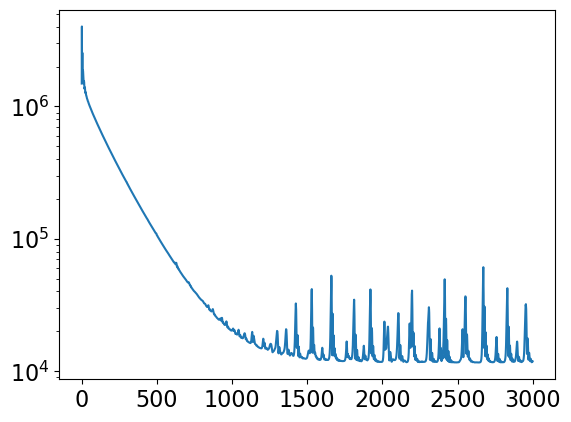


End Time  : 2023-09-18 21:56:19.531178
Plot Time : 0:00:08.197948

End Time  : 2023-09-18 21:56:19.531191
Plot Time : 0:00:00.000013

End Time  : 2023-09-18 21:56:19.531196
Infer Time : 0:00:00.000005


In [1]:
run tab_II_numpyro_gp_fft_standard.py

In [2]:
from numpyro.infer.util import log_density

In [3]:
log_density(model, model_args=(), model_kwargs={"args": args, "v_obs": v_obs_ri}, params=true_params_base)[0]

Array(-11863.7311595, dtype=float64)

In [4]:
log_density(model, model_args=(), model_kwargs={"args": args, "v_obs": v_obs_ri}, params=init_params_base)[0]

Array(-1489523.55376468, dtype=float64)

In [5]:
@jit
def U(params):
    return -1.0 * log_density(model, model_args=(), model_kwargs={"args": args, "v_obs": v_obs_ri}, params=params)[0]

In [6]:
from jax import grad

In [7]:
delU = jit(grad(U))

In [8]:
U(true_params_base) / vis_obs.size

Array(4.3939745, dtype=float64)

In [9]:
U(init_params_base) / vis_obs.size

Array(551.67539028, dtype=float64)

In [10]:
tree_map(jnp.shape, delU(true_params_base))

{'ast_k_i_base': (6, 450),
 'ast_k_r_base': (6, 450),
 'g_amp_induce_base': (4, 2),
 'g_phase_induce_base': (3, 2),
 'rfi_i_induce_base': (4, 121),
 'rfi_r_induce_base': (4, 121)}

In [11]:
import optax

In [12]:
from tqdm import tqdm

In [26]:
q_i = init_params_base
q_i = true_params_base

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-1)
state = opt.init(q_i)

grads = delU(q_i)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new) / vis_obs.size

In [27]:
history = {
    **q_i,
    "U": jnp.array([U(q_i)/vis_obs.size])
    }
history = tree_map(lambda x, y: jnp.concatenate([x[None,:], y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

In [28]:
pbar = tqdm(range(200))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 3.834: 100%|█████████████████████████████████████████████████████| 200/200 [00:06<00:00, 29.38it/s]


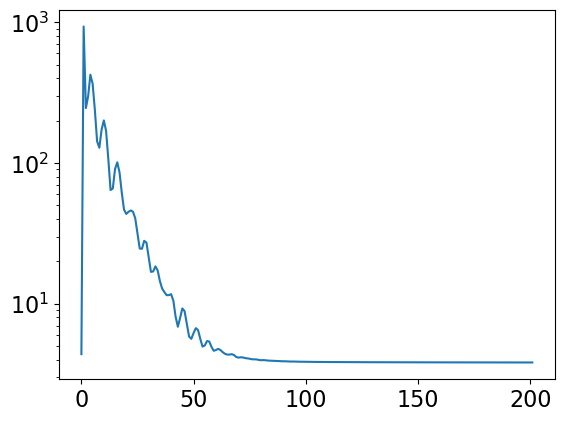

In [29]:
plt.semilogy(history['U'])

In [30]:
obs_vis, (rfi_vis, ast_vis, gains) = fixed_orbit_rfi_compressed_fft_standard_model(q_new, args)

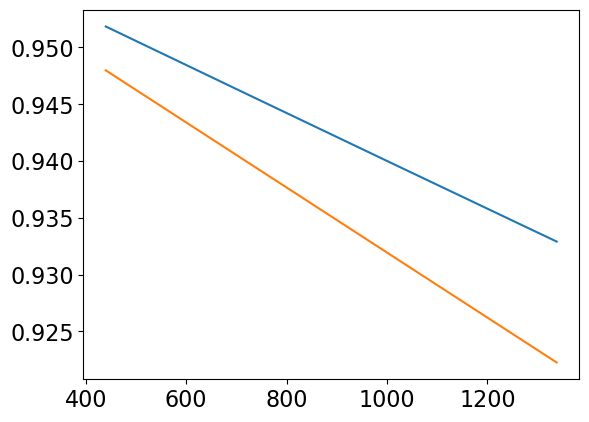

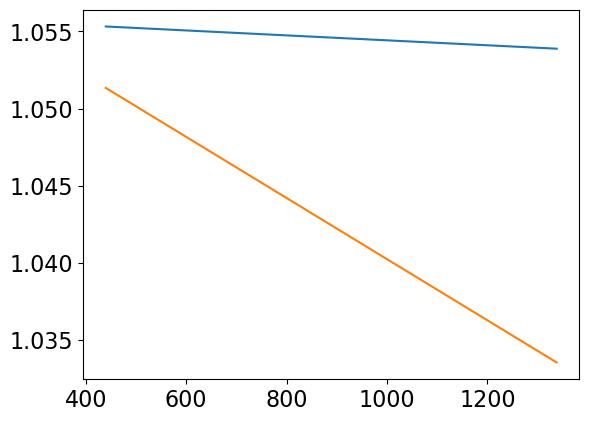

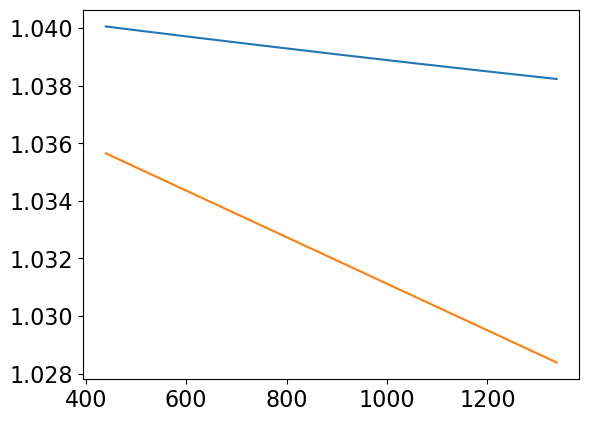

In [31]:
for b in range(3):
    plt.figure()
    plt.plot(times, jnp.abs(gains_true[:,b]))
    plt.plot(times, jnp.abs(gains[b]))

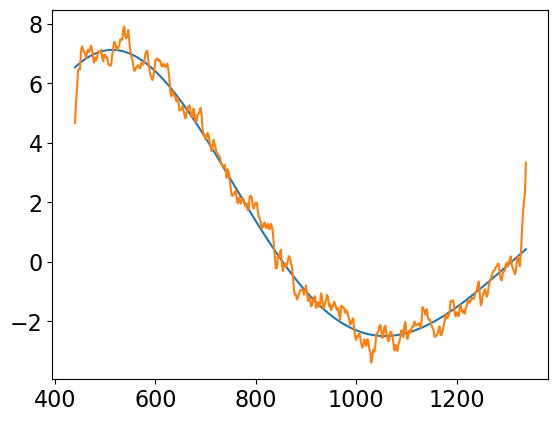

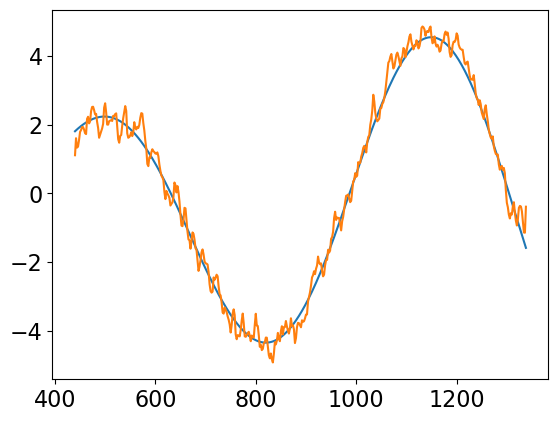

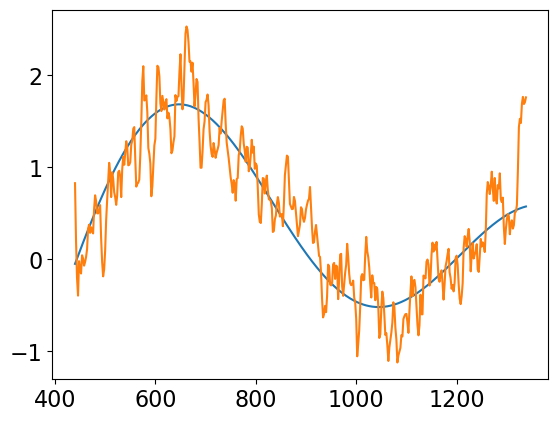

In [32]:
for b in range(3):
    plt.figure()
    plt.plot(times, vis_ast_true[:,b].real)
    plt.plot(times, ast_vis[b].real)

In [33]:
f_model = lambda params, args: fixed_orbit_rfi_compressed_fft_standard_model(params, args)[0]
model_flat = lambda params: f_model_flat(f_model, params, args)
key = random.PRNGKey(1)
# post_mean = true_params_base
post_mean = {k[:-9]: v for k, v in vi_results.params.items()}
post_mean = q_new
samples = post_samples(
    model_flat,
    post_mean,
    flatten_obs(vis_obs),
    noise,
    num_samples,
    key,
    max_cg_iter,
)

pred = Predictive(model, posterior_samples=samples)
fisher_pred = pred(random.PRNGKey(2), args=args)
plot_predictions(
    times=times,
    pred=fisher_pred,
    args=args,
    type="fisher",
    model_name=model_name,
    max_plots=10,
)

In [44]:
q_i = q_new
# q_i = true_values

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-2)
state = opt.init(q_i)

grads = delU(q_i)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new) / vis_obs.size

In [45]:
pbar = tqdm(range(100))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 5.078: 100%|█████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.44it/s]


In [30]:
q_i = q_new
# q_i = true_values

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-2)
state = opt.init(q_i)

grads = delU(q_i)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new) / vis_obs.size

In [31]:
pbar = tqdm(range(100))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 18.077: 100%|████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.41it/s]


In [49]:
q_i = q_new
# q_i = true_values

# opt = optax.adam(1e-1)
opt = optax.adabelief(1e-3)
state = opt.init(q_i)

grads = delU(q_i, params, a1, a2, bl)
updates, opt_state = opt.update(grads, state)
q_new = optax.apply_updates(q_i, updates)
U_new = U(q_new, params, a1, a2, bl) / vis_obs.size

In [50]:
pbar = tqdm(range(100))
pbar.set_description(
    f"NL Posterior = {round(float(U_new), 3)}"
)
for _ in pbar:
    grads = delU(q_new, params, a1, a2, bl)
    updates, opt_state = opt.update(grads, opt_state)
    q_new = optax.apply_updates(q_new, updates)
    U_new = U(q_new, params, a1, a2, bl) / vis_obs.size
    pbar.set_description(
        f"NL Posterior = {round(float(U_new), 3)}"
    )
    history = tree_map(lambda x, y: jnp.concatenate([x, y[None,:]], axis=0), history, {**q_new, "U": jnp.array([U_new])})

NL Posterior = 2.085: 100%|███████████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23it/s]
